(1) Importing dependency

In [1]:
import sklearn
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import maxabs_scale

import librosa
from tqdm import tqdm_notebook as tqdm
import os
import os.path as path

import numpy as np
np.random.seed(13)
import random
random.seed(13)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, \
                                    BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

(2) Get Data

In [4]:
base_dir = 'data'
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def preprocess(wav):
    wav = sklearn.preprocessing.maxabs_scale(wav)
    wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
    wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
    wav_mfcc_std_mean = wav_mfcc_std.mean(axis=1)

    features = np.concatenate([wav_mfcc_std_mean])
    return features

(3) Create a sequential model

In [9]:
model=Sequential()

# Layer 1
model.add(Conv1D (kernel_size=3, filters=128, strides=3, padding='valid',
                  kernel_initializer='he_uniform', input_shape=input_shape))                  
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 2
model.add(Conv1D (kernel_size=3, filters=128, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 3
model.add(Conv1D (kernel_size=3, filters=128, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 4
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 5
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 6
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 7
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# # Layer 8
# model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=3, strides=3))

# # Layer 9
# model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 10
model.add(Conv1D (kernel_size=3, filters=512, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 11
model.add(Dropout(0.5))
model.add(Flatten())

# Layer 12
model.add(Dense(output_size))
model.add(Activation('softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5333, 128)         512       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 5333, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 5333, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5333, 128)         49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 5333, 128)         512       
_________________________________________________________________
activation_1 (Activat

(4) Compile 

In [10]:
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
              metrics=['accuracy'])

(5) Train

In [11]:
model_path = 'model/checkpoint/SampleCNN_8_conv_SGD_2_checkpoint/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [12]:
hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=10000, 
                 validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                 callbacks = [checkpointer, early_stopping])

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10000
36800/36805 [============================>.] - ETA: 0s - loss: 1.1239 - acc: 0.6788
Epoch 00001: val_loss improved from inf to 0.42706, saving model to model/checkpoint/SampleCNN_8_conv_SGD_2_checkpoint/001-0.4271.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 1.1239 - acc: 0.6788 - val_loss: 0.4271 - val_acc: 0.8693
Epoch 2/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.4364 - acc: 0.8680
Epoch 00002: val_loss improved from 0.42706 to 0.29260, saving model to model/checkpoint/SampleCNN_8_conv_SGD_2_checkpoint/002-0.2926.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.4364 - acc: 0.8680 - val_loss: 0.2926 - val_acc: 0.9110
Epoch 3/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.3189 - acc: 0.9011
Epoch 00003: val_loss did not improve from 0.29260
36805/36805 [===============

Epoch 26/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9915
Epoch 00026: val_loss did not improve from 0.12716
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0280 - acc: 0.9915 - val_loss: 0.1399 - val_acc: 0.9632
Epoch 27/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9916
Epoch 00027: val_loss did not improve from 0.12716
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0273 - acc: 0.9915 - val_loss: 0.6944 - val_acc: 0.8668
Epoch 28/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0574 - acc: 0.9815
Epoch 00028: val_loss did not improve from 0.12716
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0574 - acc: 0.9816 - val_loss: 0.1539 - val_acc: 0.9590
Epoch 29/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9904
Epoch 00029: val_loss did not improve from 0.12716
36805/36805 [===

Epoch 85/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9941
Epoch 00085: val_loss did not improve from 0.12541
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0206 - acc: 0.9941 - val_loss: 0.1624 - val_acc: 0.9665
Epoch 86/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9969
Epoch 00086: val_loss did not improve from 0.12541
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0102 - acc: 0.9969 - val_loss: 0.2141 - val_acc: 0.9613
Epoch 87/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9987
Epoch 00087: val_loss did not improve from 0.12541
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0053 - acc: 0.9987 - val_loss: 0.1552 - val_acc: 0.9686
Epoch 88/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0043 - acc: 0.9988
Epoch 00088: val_loss did not improve from 0.12541
36805/36805 [===

Epoch 115/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9993
Epoch 00115: val_loss did not improve from 0.12541
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0031 - acc: 0.9993 - val_loss: 0.1516 - val_acc: 0.9704
Epoch 116/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9992
Epoch 00116: val_loss did not improve from 0.12541
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0030 - acc: 0.9992 - val_loss: 0.1736 - val_acc: 0.9711
Epoch 117/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9993
Epoch 00117: val_loss did not improve from 0.12541
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0028 - acc: 0.9993 - val_loss: 0.2243 - val_acc: 0.9595
Epoch 118/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0233 - acc: 0.9933
Epoch 00118: val_loss did not improve from 0.12541
36805/36805 

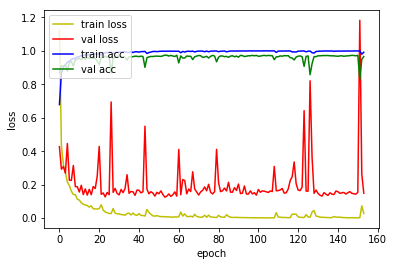

In [13]:
fig, ax = plt.subplots()
ax.plot(hist.history['loss'], 'y', label='train loss')
ax.plot(hist.history['val_loss'], 'r', label='val loss')
ax.plot(hist.history['acc'], 'b', label='train acc')
ax.plot(hist.history['val_acc'], 'g', label='val acc')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc='upper left')
plt.show()

png_path = 'visualization/learning_curve/'
filename = 'SampleCNN_8_conv_SGD'+'.png'
os.makedirs(png_path, exist_ok=True)
fig.savefig(png_path+filename, transparent=True)

In [14]:
del model

(6) Test

In [8]:
model_path = 'model/checkpoint/SampleCNN_8_conv_SGD_2_checkpoint/'
model_filename = model_path + sorted(os.listdir(model_path))[-1]
model = load_model(model_filename)
[loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
print('Loss:', loss, 'Accuracy:', accuracy)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
4815/4815 [==============================] - 5s 976us/sample - loss: 0.1782 - acc: 0.9591
Loss: 0.17821526111791205 Accuracy: 0.9590862


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
Y_pred = model.predict(x_test_abs)
y_pred = np.argmax(Y_pred, axis=1)

y_real = np.argmax(y_test_onehot, axis=1)

confusion_mat = confusion_matrix(y_real, y_pred)

print('Confusion Matrix')
print(confusion_mat)
print()

print('Classification Report')
print(classification_report(y_real, y_pred, target_names=y_table.T[0]))
print()

Confusion Matrix
[[371   0   5   2   2   0   0   2   1   2   0   0   0   0   0   0]
 [  0 347   0   0   4   4   0   0   0   6   1   0   2   0   0   0]
 [  3   0 373   2   1   0   0   1   0   0   0   0   1   2   0   1]
 [  0   0   4 359   1   0   3   2   2   0   0   0   0   0   0   6]
 [  0   1   0   1 358   3   0   0   0   1   0   0   2   0   2   0]
 [  0   1   0   0   2 396   0   1   1   2   1   4   0   0   0   0]
 [  0   0   1   1   0   0 368   0   2   0   1   1   0   0   0   0]
 [  1   0   1   0   0   2   1 367   1   0   1   1   1   0   0   0]
 [  0   0   3   4   1   1   0   1 363   1   0   0   1   1   0   0]
 [  0   3   0   0   1   5   0   0   0 363   2   2   1   0   0   0]
 [  2   0   1   0   0   0   1   0   3   1 166   7   2   0   0   0]
 [  0   1   0   3   1   0   0   0   1   2   4 138   1   2   0   0]
 [  0   0   1   0   0   0   0   0   1   0   0   0 165   0   1   0]
 [  0   0   4   0   0   0   1   1   1   0   1   1   1 182   0   0]
 [  0   0   0   0   0   0   0   0   2   1   0